In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import dask.array as da
import xarray as xr


from xmitgcm import open_mdsdataset
import xmitgcm
import ecco_v4_py as ecco


from netCDF4 import Dataset

import seawater

from analysis_package import plotting_functions
from analysis_package import open_datasets
from analysis_package import derive_potential_density_values_TEST
from analysis_package import ecco_masks

from importlib import reload

# reload modules for prototyping...
ecco_masks = reload(ecco_masks)
plotting_functions = reload(plotting_functions)
open_datasets = reload(open_datasets)
derive_potential_density_values_TEST = reload(derive_potential_density_values_TEST)


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [21]:
######################################################################################################################
################################## DEFINE DATA FILES AND THEIR ASSOCIATED PATHS ######################################
######################################################################################################################

# complete_data_dir contains ECCO state data over the entire dataset time range (1992-2016, 288 monthly mean time steps)
complete_data_dir = "./nctiles_monthly/"
# dem_dir conatins ECCO state data truncated to the first 12 monthly mean time steps
demo_dir = "./demo_nctiles_monthly/"
data_dir = complete_data_dir

# UVELMASS is the ECCO eulerian flow velocity in the (native-grid)  x-direction
UVELMASS_var = "UVELMASS"
# VVELMASS is the ECCO eulerian flow velocity in the (native-grid) y-direction
VVELMASS_var = "VVELMASS"
# BOLUS_UVEL is the ECCO lagrangian flow velocity in the (native-grid)  x-direction
BOLUS_UVEL_var = "BOLUS_UVEL"
# BOLUS_VVEL is the ECCO lagrangian flow velocity in the (native-grid) y-direction
BOLUS_VVEL_var = "BOLUS_VVEL"

# PDENS_U: Potential density interpolated to local grid cell "u" (i_g,j) points at sigma 2
PDENS_U_var_str = "PDENS_U"

# PDENS_V: Potential density interpolated to local grid cell "v" (i,j_g) points at sigma 2
PDENS_V_var_str = "PDENS_V"

GM_PSIX_var = "GM_PsiX"
GM_PSIY_var = "GM_PsiY"
######################################################################################################################
############################################ DEFINE TIMESLICE ########################################################
######################################################################################################################

time_slice = np.arange(0,12)
        

######################################################################################################################
################################################### LOAD GRID ########################################################
######################################################################################################################


grid_path = "./ecco_grid/ECCOv4r3_grid.nc"
grid = xr.open_dataset(grid_path)

######################################################################################################################
################################################### LOAD DATA ########################################################
######################################################################################################################

# load data files from central directory
UVELMASS_ds_raw = open_datasets.open_combine_raw_ECCO_tile_files(data_dir, UVELMASS_var, time_slice)
VVELMASS_ds_raw = open_datasets.open_combine_raw_ECCO_tile_files(data_dir, VVELMASS_var, time_slice)
BOLUS_UVEL_raw = open_datasets.open_combine_raw_ECCO_tile_files(data_dir, BOLUS_UVEL_var, time_slice,
                                                                rename_indices=False)
BOLUS_VVEL_raw = open_datasets.open_combine_raw_ECCO_tile_files(data_dir, BOLUS_VVEL_var, time_slice,
                                                                rename_indices=False)

GM_PSIX_ds_raw = open_datasets.open_combine_raw_ECCO_tile_files(complete_data_dir, 
                                                                GM_PSIX_var, 
                                                                time_slice)
GM_PSIY_ds_raw = open_datasets.open_combine_raw_ECCO_tile_files(complete_data_dir, 
                                                                GM_PSIY_var, 
                                                                time_slice)
# set data file indecies starting from zero.
UVELMASS_ds_raw = UVELMASS_ds_raw.assign_coords(i_g=np.arange(0,90),j=np.arange(0,90),k=np.arange(0,50),
                                                time=time_slice).chunk({"time":1,"i_g":90,"j":90,"k":50,"tile":13})
VVELMASS_ds_raw = VVELMASS_ds_raw.assign_coords(i=np.arange(0,90),j_g=np.arange(0,90),k=np.arange(0,50),
                                                time=time_slice).chunk({"time":1,"i":90,"j_g":90,"k":50,"tile":13})
BOLUS_UVEL_raw = BOLUS_UVEL_raw.assign_coords(i_g=np.arange(0,90),j=np.arange(0,90),k=np.arange(0,50),
                                              time=time_slice).chunk({"time":1,"i_g":90,"j":90,"k":50,"tile":13})
BOLUS_VVEL_raw = BOLUS_VVEL_raw.assign_coords(i=np.arange(0,90),j_g=np.arange(0,90),k=np.arange(0,50),
                                              time=time_slice).chunk({"time":1,"i":90,"j_g":90,"k":50,"tile":13})

# do some post-processing..
GM_PSIX_ds_raw = GM_PSIX_ds_raw.assign_coords(k=np.arange(0,50),j=np.arange(0,90),i=np.arange(0,90))
GM_PSIY_ds_raw = GM_PSIY_ds_raw.assign_coords(k=np.arange(0,50),j=np.arange(0,90),i=np.arange(0,90))

# trim datasets if final nan padding value is present.. otherwise this won't change anything
#GM_PSIX_ds_raw = GM_PSIX_ds_raw.isel(i=slice(0,90),j=slice(0,90),k=slice(0,50))
#GM_PSIY_ds_raw = GM_PSIY_ds_raw.isel(i=slice(0,90),j=slice(0,90),k=slice(0,50))
#GM_PSIX_ds_raw.load()
#GM_PSIY_ds_raw.load()

# add in tile coordinates
GM_PSIX_ds_raw = GM_PSIX_ds_raw.drop("lon").drop("lat")
GM_PSIY_ds_raw = GM_PSIY_ds_raw.drop("lon").drop("lat")
tiles = np.arange(0,13)
GM_PSIX_ds_raw["tile"] = tiles
GM_PSIY_ds_raw["tile"] = tiles
GM_PSIX_ds_raw = GM_PSIX_ds_raw.set_coords(["tile"]).drop("land").drop("area").drop("thic").rename({"i":"i_g"})
GM_PSIY_ds_raw = GM_PSIY_ds_raw.set_coords(["tile"]).drop("land").drop("area").drop("thic").rename({"j":"j_g"})

######################################################################################################################
################################## CALCULATE POTENTIAL DENSITY #######################################################
######################################################################################################################


# calculate potential density and in situ pressure
PDENS_U_ds_raw = open_datasets.open_combine_raw_ECCO_tile_files(data_dir,PDENS_U_var_str,time_slice,rename_indices=False)
# set data file indecies starting from zero.
PDENS_U_ds = PDENS_U_ds_raw.assign_coords(i=np.arange(0,90),j=np.arange(0,90),k=np.arange(0,50),time=time_slice).chunk({"time":1,"i":90,"j":90,"k":50,"tile":13})
# calculate potential density and in situ pressure
PDENS_V_ds_raw = open_datasets.open_combine_raw_ECCO_tile_files(data_dir,PDENS_V_var_str,time_slice,rename_indices=False)
# set data file indecies starting from zero.
PDENS_V_ds = PDENS_V_ds_raw.assign_coords(i=np.arange(0,90),j=np.arange(0,90),k=np.arange(0,50),time=time_slice).chunk({"time":1,"i":90,"j":90,"k":50,"tile":13})

######################################################################################################################
############################################# CREATE DOMAIN MASKS ####################################################
######################################################################################################################

maskW = (UVELMASS_ds_raw.UVELMASS.isel(k=0,time=1)*0 + 1.)
maskS = (VVELMASS_ds_raw.VVELMASS.isel(k=0,time=1)*0 + 1.)
maskC = (PDENS_V_ds.PDENS.isel(k=0,time=0).rename({"j_g":"j"})*0 + 1.)


southern_ocean_mask_W, southern_ocean_mask_S, so_atl_basin_mask_W, so_atl_basin_mask_S, so_indpac_basin_mask_W, so_indpac_basin_mask_S = ecco_masks.get_basin_masks(maskW, maskS, maskC)

so_atl_basin_mask_W.load()

cds = grid.coords.to_dataset()
grid_xmitgcm = ecco.ecco_utils.get_llc_grid(cds)



Loaded UVELMASS over time slice  

Loaded VVELMASS over time slice  

Loaded BOLUS_UVEL over time slice  

Loaded BOLUS_VVEL over time slice  

Loaded GM_PsiX over time slice  

Loaded GM_PsiY over time slice  

Loaded PDENS_U over time slice  

Loaded PDENS_V over time slice  



In [20]:
transport_x = (UVELMASS_ds_raw["UVELMASS"].fillna(0)*grid["drF"]*grid["dyG"])*so_atl_basin_mask_W
transport_y = (VVELMASS_ds_raw["VVELMASS"].fillna(0)*grid["drF"]*grid["dxG"])*so_atl_basin_mask_S

bolus_transport_x = (BOLUS_UVEL_raw["bolus_uvel"].fillna(0)*grid["drF"]*grid["dyG"]*grid["hFacW"])*so_atl_basin_mask_W
bolus_transport_y = (BOLUS_VVEL_raw["bolus_vvel"].fillna(0)*grid["drF"]*grid["dxG"]*grid["hFacS"])*so_atl_basin_mask_S


In [7]:
lat_vals = np.arange(-88,88)

lat_trsp_test2 = ecco.calc_meridional_trsp._initialize_trsp_data_array(cds, lat_vals)

depth_integrated_trsp_x = bolus_transport_x
depth_integrated_trsp_x.load()
depth_integrated_trsp_y = bolus_transport_y
depth_integrated_trsp_y.load()

# perform the 

depth_integrated_trsp_x = depth_integrated_trsp_x.isel(k=slice(None,None,-1))
depth_integrated_trsp_x = depth_integrated_trsp_x.cumsum(dim='k')
depth_integrated_trsp_x = -1*depth_integrated_trsp_x.isel(k=slice(None,None,-1))

depth_integrated_trsp_y = depth_integrated_trsp_y.isel(k=slice(None,None,-1))
depth_integrated_trsp_y = depth_integrated_trsp_y.cumsum(dim='k')
depth_integrated_trsp_y = -1*depth_integrated_trsp_y.isel(k=slice(None,None,-1))


#for i in range(len(transport_x.k)):
#    depth_integrated_trsp_x.loc[{'k':i}] = transport_x.isel(k=slice(i,None)).sum(dim='k')
#    depth_integrated_trsp_y.loc[{'k':i}] = transport_y.isel(k=slice(i,None)).sum(dim='k')

    
for lat in lat_vals:

    # Compute mask for particular latitude band
    lat_maskW, lat_maskS = ecco.vector_calc.get_latitude_masks(lat, cds['YC'], grid_xmitgcm)
    # Sum horizontally
    lat_trsp_x = (depth_integrated_trsp_x * lat_maskW).sum(dim=['i_g','j','tile']).mean(dim="time")
    lat_trsp_y = (depth_integrated_trsp_y * lat_maskS).sum(dim=['i','j_g','tile']).mean(dim="time")
    lat_trsp_test2.loc[{'lat':lat}] = lat_trsp_x + lat_trsp_y

    
#psi_moc2 = lat_trsp.isel(k=slice(None,None,-1))
#psi_moc2 = psi_moc2.cumsum(dim='k')



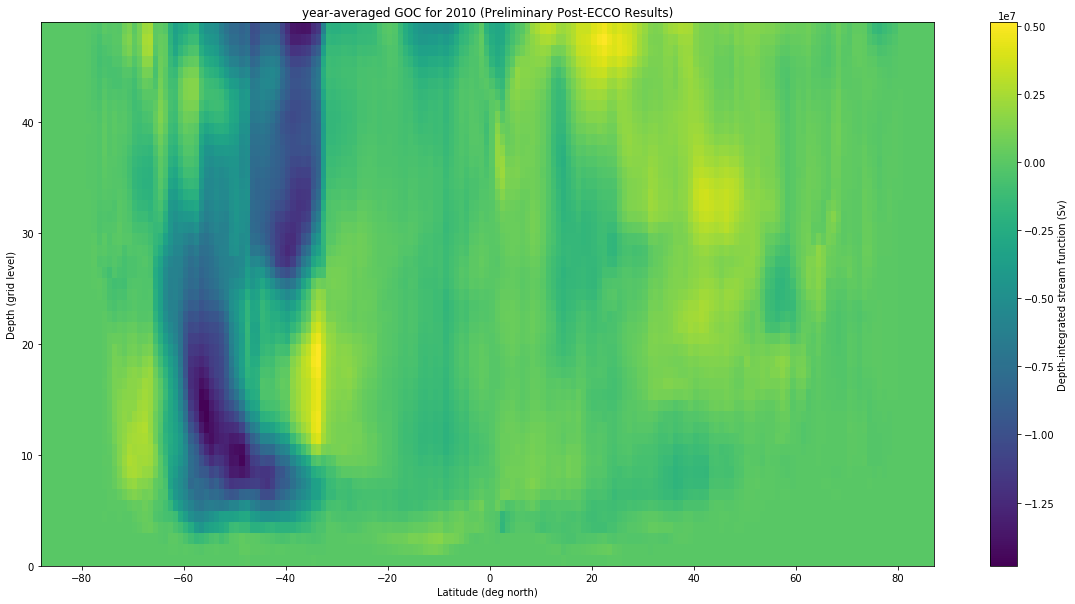

In [14]:
plt.figure(figsize=(20,10))
plt.pcolor(lat_trsp_test2.lat,lat_trsp_test2.k.isel(k=slice(0,50)),np.flip(lat_trsp_test2,axis=0).isel(k=slice(0,50)))
plt.xlabel("Latitude (deg north)")
plt.ylabel("Depth (grid level)")
plt.title("year-averaged GOC for 2010 (Preliminary Post-ECCO Results)")
cbar = plt.colorbar()
cbar.set_label("Depth-integrated stream function (Sv)")
plt.show()


In [9]:
print(lat_trsp_test2)

<xarray.DataArray (k: 50, lat: 176)>
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * lat      (lat) int64 -88 -87 -86 -85 -84 -83 -82 ... 81 82 83 84 85 86 87


In [16]:
print(lat_trsp_test2.isel(k=0))

<xarray.DataArray (lat: 176)>
array([  0.000000e+00,   0.000000e+00,   0.000000e+00,   0.000000e+00,
         0.000000e+00,   0.000000e+00,   0.000000e+00,   0.000000e+00,
         4.862403e+03,   1.174251e+05,  -3.989032e+04,   1.199357e+05,
         6.824224e+05,   6.565291e+05,   2.932583e+05,   8.107294e+04,
         2.858560e+05,   8.413147e+04,  -1.458925e+05,  -2.904653e+05,
        -2.309613e+03,   1.139989e+04,  -2.955505e+05,  -1.060295e+05,
         1.874400e+05,   8.103724e+05,   9.591744e+05,   2.483984e+06,
         3.576328e+06,   4.138767e+06,   4.754978e+06,   3.601264e+06,
         3.434600e+06,   3.568296e+06,   3.713057e+06,   4.130933e+06,
         3.973983e+06,   3.628442e+06,   3.701334e+06,   3.710438e+06,
         4.445269e+06,   2.708624e+06,   2.942497e+06,   3.624523e+06,
         3.597246e+06,   3.314278e+06,   3.156079e+06,   2.717999e+06,
         1.989290e+06,   1.358904e+06,   1.233621e+06,   1.328742e+06,
         1.206630e+06,   1.383407e+06,   1.7843